In [1]:
from jupyter_helpers.selective_import import notebooks_importer 
from Data import clinical, z_log_matrix, raw_protein_matrix

Importing Jupyter notebook from Data.ipynb


In [2]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [3]:
%R source('plots/colors.R');

### Total CSF Protein

**Actually, I am not sure what protein it is.** Is it somehow correlated with SOMAScan?

In [4]:
from scipy.stats import spearmanr

In [5]:
spearmanr(z_log_matrix.abs().sum(), clinical['Protein'])

SpearmanrResult(correlation=0.23953151843740642, pvalue=0.030203646910920208)

In [6]:
spearmanr(raw_protein_matrix.sum(), clinical['Protein'])

SpearmanrResult(correlation=0.9096450511594136, pvalue=2.9191213096280035e-32)

Yes it is. But what about the scale and units?

In [7]:
clinical['Protein'].head()

149.TMD    2.84
007.TMD    9.58
001.TMD    1.21
064.TMD    3.61
151.TMD    1.53
Name: Protein, dtype: float64

In [8]:
raw_protein_matrix.sum().head()

149.TMD    22256146.8
007.TMD    28233178.4
001.TMD    17776003.3
064.TMD    24980056.0
151.TMD    17658752.4
dtype: float64

I have no idea...

**Update after consultation with dr Rachel**:
- this is the total protein in CSF, measured independently of the SOMAScan
- the signal is assumed to be dominated by albumin
- the high correlation of the total protein CSF and summed SOMAScan values (even though we only measure about <10% of proteins) reassures us about the coherence of protein measurements

Personal research:

A recent systematic review of [total CSF protein in adults](https://www.ncbi.nlm.nih.gov/pubmed/30617996) suggests that:
- in people above the age of 50, the value of 0.60 g/L is still normal (as the median age in our cohort 36 years, we would expect the value of healthy controls to be below 0.6)
- importantly the value changes with age 
- this is regardless of gender and lab methods

A [website of an NHS hospital](https://www.gloshospitals.nhs.uk/our-services/services-we-offer/pathology/tests-and-investigations/cerebral-spinal-fluids-csf-protein-and-glucose/) suggests that:
- mild elevation (usually below 1 g/L?) is associated with viral meningitis
- moderate and high is associated with bacterial and TB meningitis

TODO: find relevant literature to support and refine these claims

Can we compare results from healthy patients to that?

In [9]:
from scipy.stats import zscore

df = clinical[['Meningitis', 'Protein']].reset_index()
df['z_score'] = df.groupby('Meningitis')['Protein'].transform(lambda x: zscore(x))

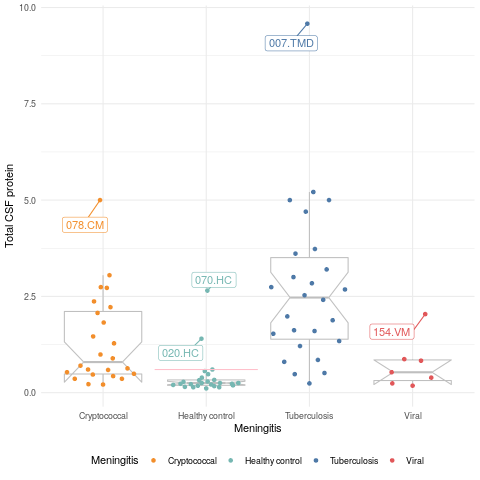

In [10]:
%%R -i df
library(ggbeeswarm)
library(ggrepel)

# prepare labels but only for potential outliers
df[df$z_score < 1.5, 'index'] = ''

(
    ggplot(df, aes(x=Meningitis, y=Protein, color=Meningitis, label=index))
    + theme_minimal()
    + geom_boxplot(outlier.shape=NA, color='grey75', notch=T)
    + geom_quasirandom()
    + scale_color_manual(values=patient_colors$Meningitis)
    + theme(legend.position='bottom')
    # TODO hide ids for publication / write-up?
    + geom_label_repel(
        position=position_quasirandom(),
        min.segment.length=.1, force=25,
        show.legend=F
    )
    # line marking the reference 0.6 value for helthy controls
    + annotate('segment', x=1.5, xend=2.5, y=0.6, yend=0.6, color='pink')
    + ylab('Total CSF protein')
)

This picture agrees with expected trends.

In [11]:
df['SOMAScan_zscore'] = zscore(raw_protein_matrix.sum())
df['TotalProtein_zscore'] = zscore(df['Protein'])

In [12]:
def reshape_for_pair_plot(df, id_vars=['index', 'Meningitis']):
    df_paired = df.melt(
        id_vars=id_vars,
        value_vars=['TotalProtein_zscore', 'SOMAScan_zscore'],
        var_name='method', value_name='zscore'
    )
    df_paired['method'] = df_paired['method'].str.replace('_zscore', '')
    df_paired['rank'] = df_paired['zscore'].rank(ascending=False)
    df_paired['shift'] = df_paired['method'].map({'TotalProtein': -1, 'SOMAScan': 1})
    return df_paired

In [13]:
df_paired = reshape_for_pair_plot(df)

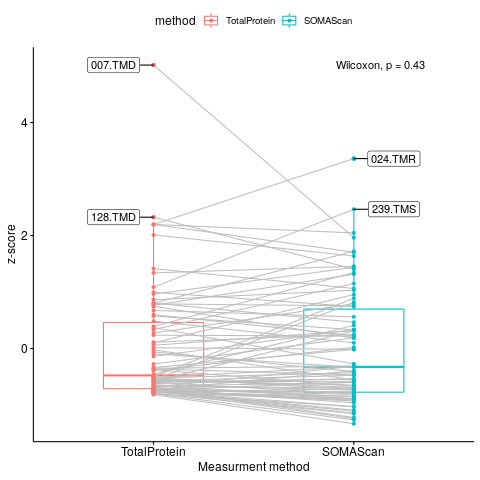

In [14]:
%%R -i df_paired
df_paired[df_paired$rank > 4, 'index'] = ''
(
    ggpubr::ggpaired(
        df_paired, x='method', y='zscore',
        color='method', line.color='gray', xlab='Measurment method'
    )
    + ggpubr::stat_compare_means(paired=T, label.x=2)
    + geom_label_repel(aes(label=index), direction='x', nudge_x=df_paired$shift/5)
    + ylab('z-score')
)

- Mann-Whitney U test (habitually referred to as Wilcoxon in R for some reason) supports the finding obtained via Spearman correlation. Note: violation of independence.
- the outliers are correlated, but
- the correlation for outliers is far from perfect, which **suggests a potential technical error - at least for the SOMAscan outliers (24, 239)** - and not necessarily the other way around (as SOMAScan measures a subset of proteins, 007 might be just missing measurements in SOMAScan).
- **the correlation seems to be higher for low values, but not for high values; this could tell us how much of the disease-driven variation we capture with SOMASscan.**
- come to think of it quantile-quantile normalization could have been nicer, though less informative.

In [15]:
df_faceted = []

for group in df.Meningitis.unique():
    mask = df.Meningitis == group
    soma = raw_protein_matrix.sum().loc[list(mask)]
    total = df[mask]['Protein']
    spearman = spearmanr(soma, total)
    df_faceted.append(DataFrame(dict(
        SOMAScan_zscore =zscore(soma),
        TotalProtein_zscore=zscore(total),
        spearman=f'r={spearman[0]:.2f}, p={spearman[1]:.2e}',
        Meningitis=group,
        index=df[mask]['index']
    )))
df_faceted = concat(df_faceted)

In [16]:
df_paired = reshape_for_pair_plot(df_faceted, id_vars=['index', 'Meningitis', 'spearman'])

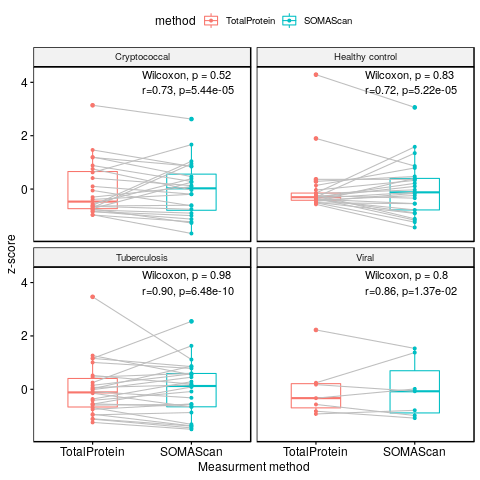

In [17]:
%%R -i df_paired
annotations = df_paired[,c('Meningitis', 'spearman')]
annotations = annotations[!duplicated(annotations),]
(
    ggpubr::ggpaired(
        df_paired, x='method', y='zscore', facet.by='Meningitis',
        color='method', line.color='gray', xlab='Measurment method'
    )
    + ggpubr::stat_compare_means(paired=T, label.x=1.5, hjust=0)
    + geom_text(data=annotations, aes(label=spearman), x=1.5, y=3.7, hjust=0)
    + ylab('z-score')
)

Intuition: if the values from SOMASscan for healthy patients correlate more with Total CSF protein than the values for diseased ones, we are missing substantial amount of disease driven variation in SOMAScan. This derives from an assumption that for healthy patients the protein levels are generally low.

The plot above shows that:
- the correlation appears to be roughly the same for each of the patient groups, thus
- if a disease modulates only a fraction of proteins, the SOMAScan panel covers substantial amount of them (here naively assuming that the contributions of each protein is comparable)
- if a disease modulates most of the proteins, we cannot claim the above
- if a fraction of proteins drives the overall change in protein level, we got this fraction covered by SOMAScan (the suspected effect of albumin) 

#### Does albumin explain most of the variation?

In [18]:
albumin = raw_protein_matrix.loc['Albumin']
spearmanr(albumin, clinical['Protein'])

SpearmanrResult(correlation=0.8947110675505742, pvalue=9.84177497838464e-30)

Interesting, the correlation is lower than the overall correlation...

Are there any other albumin isoforms?

First, I will look up by the full name:

In [19]:
relevant_aptamers = read_csv('data/other/relevant_aptamers.csv')

In [20]:
relevant_aptamers[relevant_aptamers.TargetFullName.str.lower().str.contains('albumin')]

,Unnamed: 0,AptamerId,SomaId,Target,TargetFullName,...,Type,PlasmaDilution,SerumDilution,IsIn1310Panel,IsIn1129Panel
246,249,3707-12,SL000254,Albumin,Serum albumin,...,Protein,0.005,0.005,1,1


Then, I check by the correlations:

In [21]:
from helpers.r import p_adjust

In [22]:
def somascan_correlations(reference, data=raw_protein_matrix, mask=None, method=spearmanr):
    if mask is not None:
        mask = list(mask)
        data = data[data.columns[mask]]
        reference = reference[mask]
    df = data.apply(lambda protein: method(protein, reference), axis=1)
    df = DataFrame(df.values.tolist(), index=data.index, columns=['correlation', 'pvalue'])
    df['qvalue'] = p_adjust(df.pvalue.tolist())
    df['full_name'] = relevant_aptamers.set_index('Target')['TargetFullName'][df.index]
    df['% of sum(SOMAScan)'] = 100 * data.sum(axis=1) / data.sum().sum()
    return df.sort_values('correlation')

In [23]:
albumin_correlations = somascan_correlations(albumin)
albumin_correlations.tail(10)

,correlation,pvalue,qvalue,full_name,% of sum(SOMAScan)
target,,,,,
C5,0.927014,8.053779e-36,1.043770e-32,Complement C5,0.263528
Prekallikrein,0.927188,7.345019e-36,9.526490e-33,Plasma kallikrein,0.707306
"C5b, 6 Complex",0.928821,3.062141e-36,3.977721e-33,Complement C5b-C6 complex,0.075634
HRG,0.928821,3.062141e-36,3.977721e-33,Histidine-rich glycoprotein,0.180771
Plasminogen,0.930736,1.067815e-36,1.388159e-33,Plasminogen,0.263125
HGFA,0.932217,4.633136e-37,6.027710e-34,Hepatocyte growth factor activator,0.263545
a2-HS-Glycoprotein,0.937288,2.280911e-38,2.969747e-35,Alpha-2-HS-glycoprotein,0.148111
Angiostatin,0.940183,3.644898e-39,4.749301e-36,Angiostatin,0.032770
Apo A-I,0.950022,3.337059e-42,4.351525e-39,Apolipoprotein A-I,0.332351


I do not see any obvious albumin isoforms nor albumin-like proteins. There are three isoforms in UniProt at the time of writing (April 12th '19) and eight non-annotated matches for 90% similarity query, non of which overlaps with the list above, so I conclude that the lower than expected overall correlation of albumin is a thing.

Though, maybe I should have been looking at the healthy patients only?

In [24]:
is_healthy = clinical.Meningitis == 'Healthy control'

In [25]:
somascan_correlations(clinical['Protein'], mask=is_healthy).loc['Albumin']

correlation                0.654987
pvalue                  0.000380687
qvalue                     0.325868
full_name             Serum albumin
% of sum(SOMAScan)         0.501776
Name: Albumin, dtype: object

Well, it's even worse! Albumin still might compose a considerable proportion of the CSF proteins, but it appears that it does not drive nor define it (NB: assuming correctness of SOMAScan and acknowledging low sample size).

Also, albumin accounts only for 0.6% (0.5% for healthy patients) of the total protein abundance in SOMAScan-measured CSF proteins.

Some sanity checks are needed, **did we really expect albumin to be high?** (or did I just misunderstand something at the meeting?)

Yes!

- "The same as in blood, albumin is the most concentrated protein, representing 35–80% of total CSF protein" [Editorial on “Cerebrospinal fluid total protein reference intervals derived from 20 years of patient data”, 2018](http://jlpm.amegroups.com/article/view/4323/5321)
  - just a paragraph-level reference to [Proteins in cerebrospinal fluid and blood: Barriers, CSF flow rate and source-related dynamics, 2003](https://www.ncbi.nlm.nih.gov/pubmed/14530572) (TODO: read in full), which states that:
    > The main fraction of proteins in the normal cerebrospinal fluid originates from blood, e.g. albumin which constitutes 35–80% of total protein in CSF[11]
  - which leads us to [Cerebrospinal fluid analysis: disease-related data patterns and evaluation programs, 2001](https://www-sciencedirect-com.iclibezp1.cc.ic.ac.uk/science/article/pii/S0022510X00005013). Table 2 contains relevant statistics. There are references to previous studies investigating the prevalence of albumin, see [(Ganrot and Laurell, 1974)](http://clinchem.aaccjnls.org/content/20/5/571.short) discussed below 
- many studies discuss the ratio of albumin/total CSF etc as a marker for TBM and other meningitis diseases, though do not necessarily claim albumin to be high on its own

Possible explanations:
- data analyst issue: I may be missing something 
- technical issue:
  - SOMAScan may fail to capture the abundance of albumin
  - a fraction of albumin might have been filtered out in the sample treatment
- literature issue (less likely): albumin may not be the most concentrated protein in CSF

A further check supports the second option, as according to the literature:

> A high correlation (r = 0.85) normally exists between the concentration of albumin and of IgG in cerebrospinal fluid (CSF) 
[(Ganrot and Laurell, 1974)](http://clinchem.aaccjnls.org/content/20/5/571.short)

In [26]:
albumin_correlations.loc['IgG']

correlation                   0.153078
pvalue                        0.169749
qvalue                               1
full_name             Immunoglobulin G
% of sum(SOMAScan)             1.16857
Name: IgG, dtype: object

In [27]:
# healthy patients only:
somascan_correlations(albumin, mask=is_healthy).loc['IgG']

correlation                  0.0192308
pvalue                        0.927302
qvalue                               1
full_name             Immunoglobulin G
% of sum(SOMAScan)             1.75922
Name: IgG, dtype: object

Well, not if measured by SOMAScan

#### If not albumin, what correlates the most with the total CSF protein?

In [28]:
total_protein_correlations = somascan_correlations(clinical['Protein'])
total_protein_correlations

,correlation,pvalue,qvalue,full_name,% of sum(SOMAScan)
target,,,,,
Kallikrein 7,-0.715460,4.270795e-14,1.627173e-11,Kallikrein-7,0.025559
IGF-I,-0.696270,3.802914e-13,1.300597e-10,Insulin-like growth factor I,0.107171
Semaphorin 3E,-0.643500,7.021849e-11,1.994205e-08,Semaphorin-3E,0.014663
ON,-0.605066,1.734593e-09,4.423213e-07,SPARC,0.507669
IDS,-0.582066,9.717538e-09,2.283621e-06,Iduronate 2-sulfatase,0.021610
...,...,...,...,...,...
"C5b, 6 Complex",0.944128,2.570815e-40,3.344630e-37,Complement C5b-C6 complex,0.075634
C5,0.944215,2.419436e-40,3.150106e-37,Complement C5,0.263528
DC-SIGNR,0.945554,9.398676e-41,1.224647e-37,C-type lectin domain family 4 member M,0.078448


And where is albumin in the ranked list?

In [29]:
total_protein_correlations.rank(ascending=False).loc['Albumin'].correlation

113.0

There are 112 proteins (about 8%) that correlate more with the total CSF than albumin (using data from all patients).

Which proteins have the highest contribution to the abundance as measured by SOMAScan? Do these corrrelate with total CSF?

In [30]:
total_protein_correlations.sort_values('% of sum(SOMAScan)').tail(10)

,correlation,pvalue,qvalue,full_name,% of sum(SOMAScan)
target,,,,,
C9,0.764496,6.408260e-17,3.210538e-14,Complement component C9,1.215595
CNDP1,0.133306,2.324987e-01,1.000000e+00,Beta-Ala-His dipeptidase,1.257596
PEDF,-0.043496,6.980101e-01,1.000000e+00,Pigment epithelium-derived factor,1.261949
Transferrin,0.053521,6.329686e-01,1.000000e+00,Serotransferrin,1.265309
amyloid precursor protein,-0.260224,1.822173e-02,1.000000e+00,Amyloid beta A4 protein,1.348588
a1-Antichymotrypsin,-0.072460,5.176747e-01,1.000000e+00,Alpha-1-antichymotrypsin,1.350698
Antithrombin III,0.436743,4.093352e-05,6.099094e-03,Antithrombin-III,1.377927
Apo E4,-0.038543,7.310020e-01,1.000000e+00,Apolipoprotein E (isoform E4),1.425484
Apo E2,-0.043909,6.952789e-01,1.000000e+00,Apolipoprotein E (isoform E2),1.614840


The lack of correlation with the total CSF protein for the most abundant proteins measured by SOMAScan is slightly surprising. Together with high overall correlation (0.9!), it suggests that **the total CSF protein increase is driven by small contributions of numerous proteins**. Which might have been expected given the previous PCA analysis which showed the clear increase in fraction of proteins from inside of the cells being detected in the diseased patients (and the disease status  correlates with high CSF total protein).

Side note: would the the lowest values come hand to define noise levels?

In [31]:
total_protein_correlations.sort_values('% of sum(SOMAScan)').head(5)

,correlation,pvalue,qvalue,full_name,% of sum(SOMAScan)
target,,,,,
CTLA-4,0.495214,2.247226e-06,4.045006e-04,Cytotoxic T-lymphocyte protein 4,0.000053
Neurotrophin-3,0.491738,2.711666e-06,4.799649e-04,Neurotrophin-3,0.000070
NANOG,0.581118,1.040361e-08,2.424041e-06,Homeobox protein NANOG,0.000083
FER,0.770128,2.744937e-17,1.441092e-14,Tyrosine-protein kinase Fer,0.000085
LRRT1,0.597530,3.096856e-09,7.711171e-07,Leucine-rich repeat transmembrane neuronal pro...,0.000088


And in healthy patients only:

In [32]:
somascan_correlations(clinical['Protein'], mask=is_healthy)

,correlation,pvalue,qvalue,full_name,% of sum(SOMAScan)
target,,,,,
TGF-b2,-0.453303,2.286204e-02,1.000000,Transforming growth factor beta-2,0.000320
Cathepsin D,-0.444744,2.590856e-02,1.000000,Cathepsin D,1.509303
a1-Antichymotrypsin,-0.437813,2.860860e-02,1.000000,Alpha-1-antichymotrypsin,2.060182
PEDF,-0.431267,3.136177e-02,1.000000,Pigment epithelium-derived factor,1.911921
Apo E3,-0.391221,5.313312e-02,1.000000,Apolipoprotein E (isoform E3),2.523853
...,...,...,...,...,...
LRRK2,0.843281,1.207165e-07,0.000157,Leucine-rich repeat serine/threonine-protein k...,0.001867
C5a,0.849827,7.644868e-08,0.000100,C5a anaphylatoxin,0.001288
sICAM-2,0.851753,6.656401e-08,0.000087,Intercellular adhesion molecule 2,0.001138


Meningitis only:

In [33]:
somascan_correlations(clinical['Protein'], mask=~is_healthy)

,correlation,pvalue,qvalue,full_name,% of sum(SOMAScan)
target,,,,,
IGF-I,-0.670816,1.133503e-08,5.214114e-06,Insulin-like growth factor I,0.077420
Kallikrein 7,-0.584760,1.784080e-06,5.566331e-04,Kallikrein-7,0.010763
DHH,-0.507358,5.626728e-05,1.367295e-02,Desert hedgehog protein N-product,0.003297
IDS,-0.476015,1.821429e-04,3.988929e-02,Iduronate 2-sulfatase,0.014244
Nr-CAM,-0.463471,2.825962e-04,5.849741e-02,Neuronal cell adhesion molecule,0.258409
...,...,...,...,...,...
C5,0.925321,7.925619e-25,1.031123e-21,Complement C5,0.302105
Coagulation Factor IXab,0.926358,5.469649e-25,7.121483e-22,Coagulation factor IXab,0.354175
"C5b, 6 Complex",0.928951,2.112253e-25,2.752266e-22,Complement C5b-C6 complex,0.089011


When looking at the exact values and not on the ranks only:

In [34]:
from scipy.stats import pearsonr

In [35]:
somascan_correlations(clinical['Protein'], mask=~is_healthy, method=pearsonr)

,correlation,pvalue,qvalue,full_name,% of sum(SOMAScan)
target,,,,,
IGF-I,-0.628917,1.614006e-07,1.525236e-04,Insulin-like growth factor I,0.077420
PIANP,-0.410053,1.535903e-03,4.131579e-01,PILR alpha-associated neural protein,0.207425
Nr-CAM,-0.397267,2.214453e-03,5.580420e-01,Neuronal cell adhesion molecule,0.258409
Kallikrein 7,-0.396996,2.231389e-03,5.580420e-01,Kallikrein-7,0.010763
PKC-G,-0.378785,3.666408e-03,8.286083e-01,Protein kinase C gamma type,0.001945
...,...,...,...,...,...
C5,0.820793,5.449453e-15,7.089739e-12,Complement C5,0.302105
AK1A1,0.824479,3.239108e-15,4.217319e-12,Alcohol dehydrogenase [NADP(+)],0.306103
SLAF7,0.833139,9.086920e-16,1.184026e-12,SLAM family member 7,0.040507


Key take-aways:
 - albumin may not be the key player (or it might not be measured proportionally by SOMAScan)
 - there are many proteins having levels highly and positively correlated with the total protein abundance in CSF; these are candidates for further investigation at some point;
 - while some of such proteins may be interesting to look at, my intuition is that these may not be the best candidates for >>novel<< biomarkers - we already know of the correlation between total CSF protein and disease status. Thus:
  - negative correlations might be of more interest - these are less obvious; observing lower level of such proteins might relevant for diagnosis 
  - it might be worth keeping this list to highlight proteins highly correlated with total CSF protein in the final biomarker candidates results; this would inform the reader of this special relation with its pros and cons (pro: can be easily measured; con: is already being measured indirectly by total CSF protein)

 - IGF-I negatively correlates with the total protein in CSF is diseased patients (which is associated with the disease status itself). A [study from 2012](https://journals.lww.com/infectdis/Abstract/2012/03000/Cerebrospinal_Fluid_and_Serum_Levels_of_Growth.9.aspx?trendmd-shared=0) investigated this topic [disclaimer: I read only abstract].
 - Kallikrein 7 may be interesting to investigate. I did not find relevant literature, except for Kallikrein-6 under-expression reported in
 - [iTRAQ-based quantitative proteomic analysis of cerebrospinal fluid reveals NELL2 as a potential diagnostic biomarker of tuberculous meningitis](https://www.spandidos-publications.com/ijmm/35/5/1323), table II which is an important article and table but to avoid biasing myself with such knowledge (and straying off the topic) I will leave comparisons for later